In [1]:
!pip install osmnx >> log.txt
!pip install matplotlib >> log.txt
!pip install optalgotools >> log.txt
!pip install folium >> log.txt
!pip install tqdm >> log.txt

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt


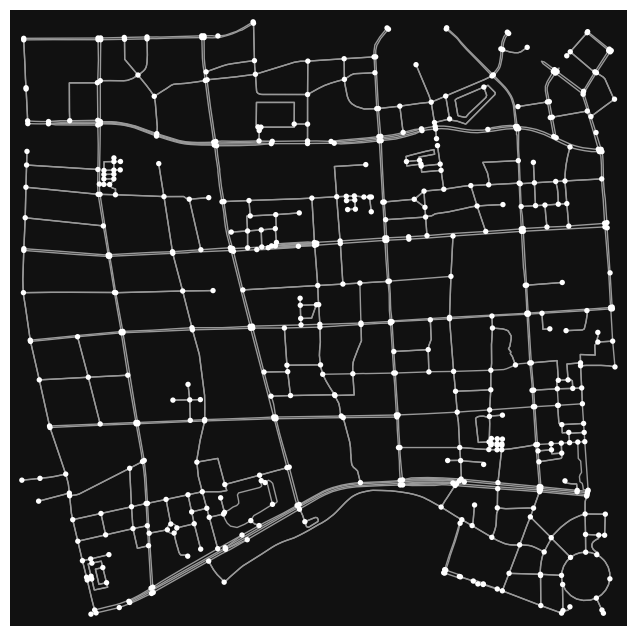

In [3]:
GuDang = (30.284698, 120.109238)

# find by coordinate
graph = ox.graph_from_point(GuDang, network_type='drive', dist=2100)
fig, ax = ox.plot_graph(graph)


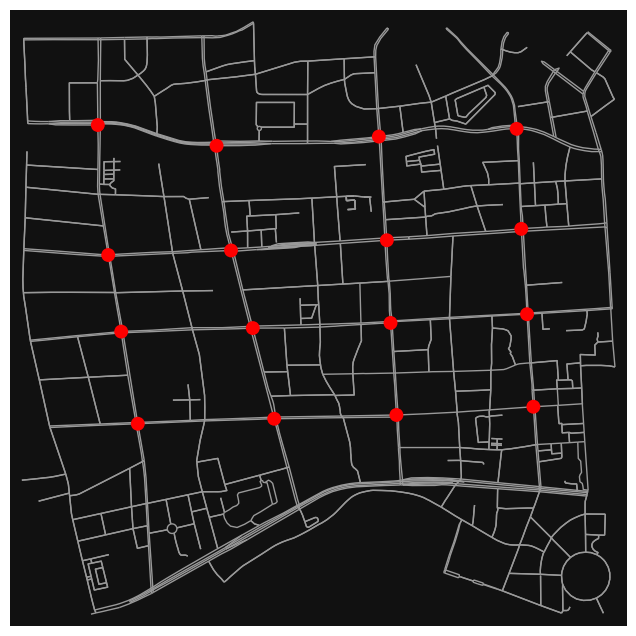

In [5]:
#Intersec: Osmid        lat       lon            row col  (bottom-to-up, left-to-right)
node_1_1 = 27127956   # 30.278049 120.096021     1    1
node_1_2 = 26496837   # 30.278366	120.106039     1    2
node_1_3 = 3382408994 # 30.278606	120.115016     1    3
node_1_4 = 26197702   # 30.279129 120.125075     1    4
node_2_1 = 332556593  # 30.283895	120.094802     2    1
node_2_2 = 26607405   # 30.284117	120.10446      2    2
node_2_3 = 26197709   # 30.284443	120.114585     2    3
node_2_4 = 26197716   # 30.284997 120.124611     2    4
node_3_1 = 332556598  # 30.288751	120.093849     3    1
node_3_2 = 33720424   # 30.289040	120.102869     3    2
node_3_3 = 262910008  # 30.289688	120.114313     3    3
node_3_4 = 26197727   # 30.290408	120.124187     3    4
node_4_2 = 2908449025 # 30.295688	120.101862	   4    2
node_4_3 = 30067206   # 30.296274	120.113794     4    3
node_4_1 = 2908449017 # 30.296996 120.093084     4    1
node_4_4 = 31885920   # 30.296754 120.123847     4    4

targetIntersection = [
    node_1_1, node_1_2, node_1_3, node_1_4,
    node_2_1, node_2_2, node_2_3, node_2_4,
    node_3_1, node_3_2, node_3_3, node_3_4,
    node_4_1, node_4_2, node_4_3, node_4_4
]

# Create a list of node colors: default color for most nodes and a special color for the highlighted nodes
nc = ['r' if node in targetIntersection else 'none' for node in graph.nodes()]

# Create a list of node sizes: larger size for the highlighted nodes and default size for the rest
ns = [100 if node in targetIntersection else 10 for node in graph.nodes()]

# Plot the graph with the specified node colors and sizes
fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns)


The dataset that we want to load related to the traffic volume of the above 16 intersections.

In [13]:
import json
import matplotlib.pyplot as plt
import argparse
import sys
from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = 'ECE1724/hangzhou_4x4_gudang_18041610_1h'

# Different Google Drive User would have different path,
# please upload the files to your own Google drive
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/MyDrive/$FOLDERNAME

with open("roadnet_4X4.json", 'r') as road_file:
    road_data = json.load(road_file)

# Load the newly uploaded data
with open("hangzhou_4x4_gudang_18041610_1h.json", "r") as file:
    new_volume_data = json.load(file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ECE1724/hangzhou_4x4_gudang_18041610_1h


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extract roads and intersections from roadnet_data
intersections = road_data['intersections']
roads = road_data['roads']

# Create a dictionary to store traffic volume for each road
traffic_volume = {road['id']: 0 for road in roads}

# Update traffic_volume based on traffic_data
for entry in new_volume_data:
    for road_id in entry['route']:
        traffic_volume[road_id] += 1

def add_arrow(ax, start_x, start_y, end_x, end_y, color):
    """Add an arrow to the plot to indicate road direction."""
    offset = 50  # Offset to shift the arrow for visibility
    shrink_factor = 0.7  # Factor to shorten the arrow

    # Calculate the direction of the road
    dx = end_x - start_x
    dy = end_y - start_y

    # Normalize the direction
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length

    # Calculate offset starting and ending points for the arrow, and shorten the arrow
    arrow_start_x = start_x + dy * offset + dx * (1 - shrink_factor) * length / 2
    arrow_start_y = start_y - dx * offset + dy * (1 - shrink_factor) * length / 2
    arrow_end_x = end_x + dy * offset - dx * (1 - shrink_factor) * length / 2
    arrow_end_y = end_y - dx * offset - dy * (1 - shrink_factor) * length / 2

    # Plot the arrow
    ax.arrow(arrow_start_x, arrow_start_y, arrow_end_x - arrow_start_x, arrow_end_y - arrow_start_y,
             head_width=50, head_length=50, fc=color, ec=color)

def add_text(ax, start_x, start_y, end_x, end_y, text):
    """Add text to the plot."""
    offset = 80  # Offset to shift the text for visibility

    # Calculate the direction of the road
    dx = end_x - start_x
    dy = end_y - start_y

    # Normalize the direction
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length

    # Calculate offset position for the text
    text_x = (start_x + end_x) / 2 + dy * offset
    text_y = (start_y + end_y) / 2 - dx * offset

    # Add the text
    ax.text(text_x, text_y, text, fontsize=10, ha='center', va='center', color='grey')

def visualize_traffic_red_with_shortened_arrows(intersections, roads, traffic_volume):
    fig, ax = plt.subplots(figsize=(13, 10))
    max_volume = max(traffic_volume.values())

    # Draw intersections
    for intersection in intersections:
        x, y = intersection['point']['x'], intersection['point']['y']
        ax.plot(x, y, 'o', color='blue')

    # Draw roads, overlay traffic volume, and add shortened offset arrows and offset text
    for road in roads:
        start_x, start_y = road['points'][0]['x'], road['points'][0]['y']
        end_x, end_y = road['points'][1]['x'], road['points'][1]['y']

        color_intensity = traffic_volume[road['id']] / max_volume
        ax.plot([start_x, end_x], [start_y, end_y], color=plt.cm.Reds(color_intensity), linewidth=5)

        # Add shortened direction arrow with an offset
        add_arrow(ax, start_x, start_y, end_x, end_y, plt.cm.Reds(color_intensity))

        # Add offset text
        add_text(ax, start_x, start_y, end_x, end_y, str(traffic_volume[road['id']]))

    # Set a colormap for traffic volume
    norm = plt.Normalize(min(traffic_volume.values()), max(traffic_volume.values()))
    cmap = plt.cm.Reds

    # Add colorbar to indicate traffic volume
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Traffic Volume")

    ax.set_title("Traffic Volume Visualization with Direction")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

visualize_traffic_red_with_shortened_arrows(intersections, roads, traffic_volume)


NameError: name 'road_data' is not defined



Here is a visualization of the dataset detailing traffic volume across 16 specific intersections, arranged in a 4x4 grid. The data captures one hour of traffic in the Gudang sub-district of Hangzhou, China. Traffic density is represented by shades of red, with darker hues indicating higher volumes. Arrows denote the direction of traffic flow on each road.

The plot provides insights into traffic distribution in the area and delineates the flow in each direction. Some edges, where one of the arrows has a value of 0, indicate that the road is one-way.Notably, bottlenecks are evident at the intersections of node_4_1 and node_4_4, as well as along the Yuhangtang and Gudun Roads. Additionally, the spatial distribution reveals a propagation trend in traffic volume. That is, roads or intersections with high traffic often neighbor others with similarly high traffic volumes, which conforma to our common sense. As high traffic areas might also be zones of potential accidents,this spatial representaion could stress which intersections we should look at when designing proper traffic light strategy.

In [15]:
#Helper function for accurate calculating distance
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Radius of Earth in kilometers

    return distance

# distance between nodes of id osmid_1 and osmid_2, unit of km
def cal_distance_with_id(osmid_1, osmid_2):

    # Fetch the nodes' data
    node_1 = graph.nodes[osmid_1]
    node_2 = graph.nodes[osmid_2]

    # Extract the coordinates
    lat1, lon1 = node_1['y'], node_1['x']
    lat2, lon2 = node_2['y'], node_2['x']
    distance = haversine_distance(lat1, lon1, lat2, lon2)

    return distance

# cost function for a sepcific route
def cost(route):
    total_cost = 0
    for u, v in zip(route[:-1], route[1:]):
        try:
            total_cost += cal_distance_with_id(u, v)
        except KeyError:
            # With the current modification, there should be no KeyError.
            with open("error.txt", "a") as f:
                print(u, v)
                print("Error calculating cost between nodes {u} and {v}.", file=f)
            return float('inf')

    return total_cost

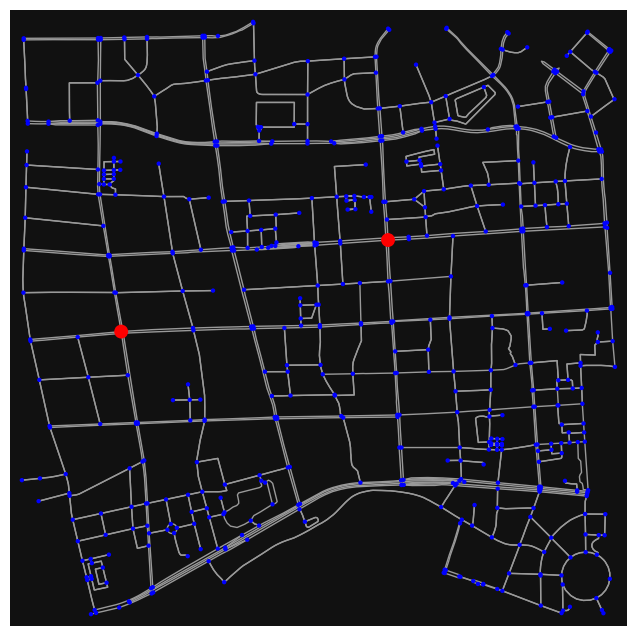

In [16]:
# Adding markers to 2 POIs on the map

# Specify the start and end nodes(Two points of interested)
start_node = 332556593  # row: 2  col:  1
end_node = 262910008    # row: 3  col:  3

# Create a list of node colors: default color for most nodes and a special color for the highlighted nodes
nc = ['r' if node == start_node or node == end_node else 'b' for node in graph.nodes()]

# Create a list of node sizes: larger size for the highlighted nodes and default size for the rest
ns = [100 if node == start_node or node == end_node else 10 for node in graph.nodes()]

# Plot the graph with the specified node colors and sizes
fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns)


Cost of BFS route: 2.51000462494887
Execution time: 0.003960132598876953 seconds


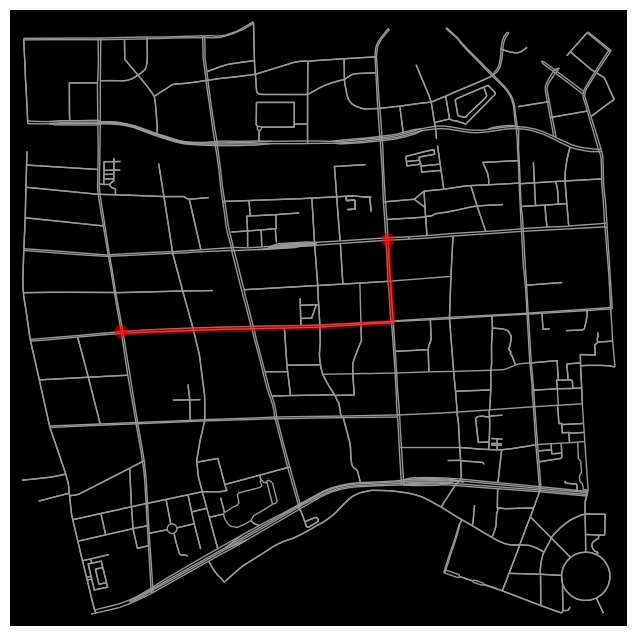

In [17]:
import networkx as nx
import time

from optalgotools import routing

start_time = time.time()

# Generate a BFS tree from the start node
bfs_tree = nx.bfs_tree(graph, source=start_node)

# Traverse the BFS tree to get the route from the start node to the end node
bfs_route = [end_node]
while bfs_route[-1] != start_node:
    bfs_route.append(list(bfs_tree.predecessors(bfs_route[-1]))[0])
bfs_route = bfs_route[::-1]  # reverse the route to start from the start node

end_time = time.time()

cost_of_bfs = cost(bfs_route)
time_of_bfs = end_time - start_time
print("Cost of BFS route:", cost_of_bfs)
print(f"Execution time: {time_of_bfs} seconds")

# Plot the route
fig, ax = ox.plot_graph_route(graph, bfs_route, route_linewidth=4, node_size=0, bgcolor='k')

routing.draw_route(graph, bfs_route)



Cost of DFS route: 8.512414000328082
Execution time: 0.0006687641143798828 seconds


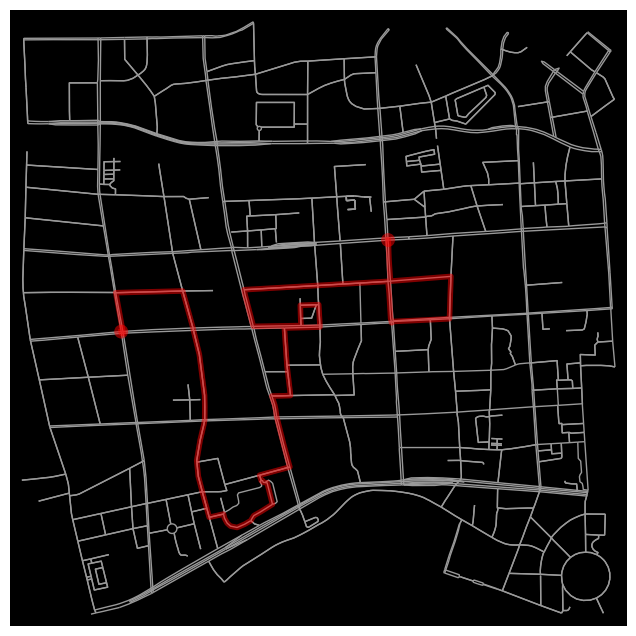

In [18]:
start_time = time.time()

# DFS Implementation
def dfs(graph, start, end, visited=None, path=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []

    visited.add(start)
    path.append(start)

    if start == end:
        return path

    for neighbor in graph[start]:
        if neighbor not in visited:
            new_path = dfs(graph, neighbor, end, visited, path.copy())
            if new_path:  # If a path is returned, that means we found the target node
                return new_path

    return None

dfs_route = dfs(graph, start_node, end_node)

end_time = time.time()

cost_of_dfs = cost(dfs_route)
time_of_dfs = end_time - start_time
print("Cost of DFS route:", cost_of_dfs)
print(f"Execution time: {time_of_dfs} seconds")

# Plot the route
fig, ax = ox.plot_graph_route(graph, dfs_route, route_linewidth=4, node_size=0, bgcolor='k')

routing.draw_route(graph, dfs_route)


Cost of Dijkastra route: 2.51000462494887
Execution time: 0.02023935317993164 seconds


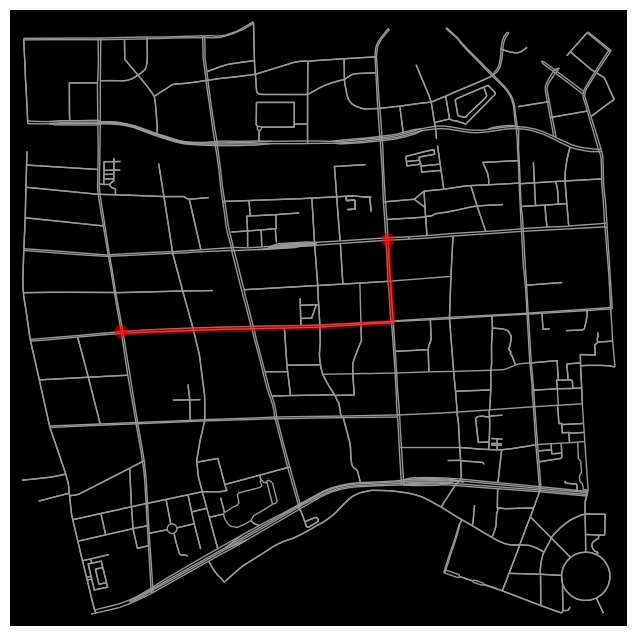

In [19]:
start_time = time.time()

# Find the shortest path using Dijkstra's algorithm
dijkstra_route = nx.shortest_path(graph, source=start_node, target=end_node, method='dijkstra')

end_time = time.time()

cost_of_dijkastra = cost(dijkstra_route)
time_of_dijkastra = end_time - start_time
print("Cost of Dijkastra route:", cost_of_dijkastra)
print(f"Execution time: {time_of_dijkastra} seconds")

# Plot the route
fig, ax = ox.plot_graph_route(graph, dijkstra_route, route_linewidth=4, node_size=0, bgcolor='k')

routing.draw_route(graph, dijkstra_route)

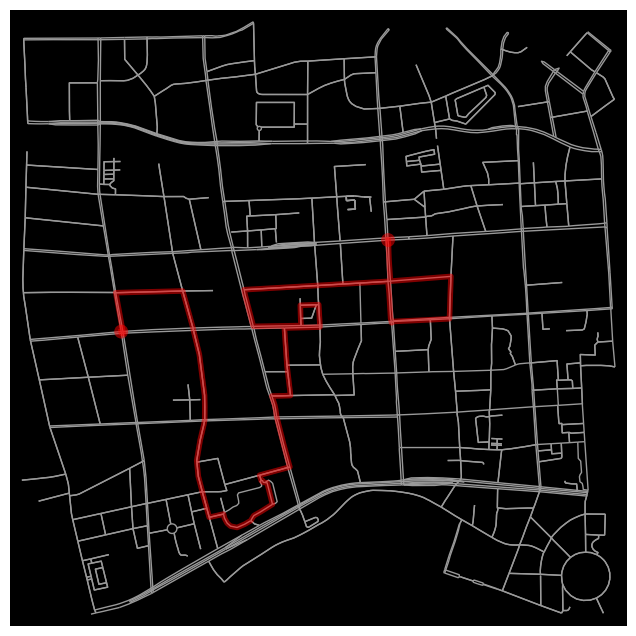

round: 19 . Update best route with new cost of 8.228120117022794
round: 19 . Annealing
round: 58 . Update best route with new cost of 8.080702778294501
round: 58 . Annealing
round: 59 . Update best route with new cost of 7.313775406575982
round: 59 . Annealing
round: 60 . Update best route with new cost of 7.023686682738209
round: 60 . Annealing
round: 69 . Update best route with new cost of 6.621144150530022
round: 69 . Annealing
round: 75 . Update best route with new cost of 4.669125638895025
round: 75 . Annealing
round: 83 . Update best route with new cost of 4.639111281566079
round: 83 . Annealing
round: 117 . Update best route with new cost of 3.101316475310321
round: 117 . Annealing
round: 138 . Update best route with new cost of 2.51000462494887
round: 138 . Annealing
Total round: 917
Cost of SA route: 2.51000462494887
Execution time: 5.493026971817017 seconds
2.51000462494887


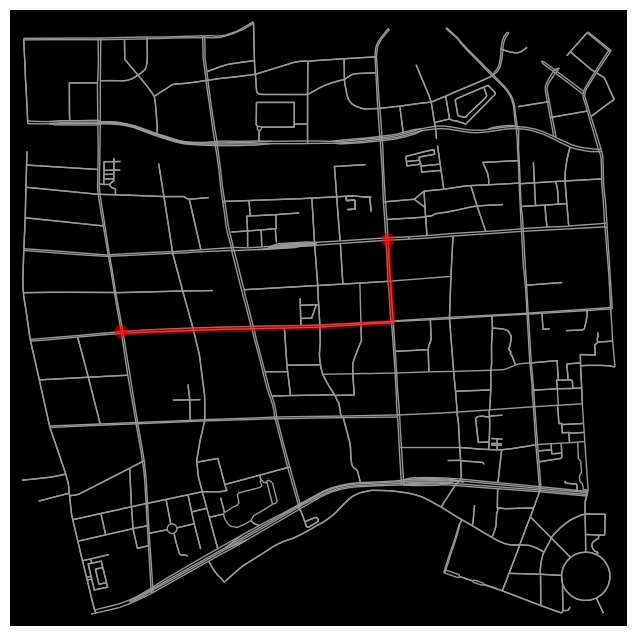

In [20]:
# We set the initial solution to be the route we got from the DFS traversal
route = dfs_route

import random

# Get the original DFS route for comparision
fig, ax = ox.plot_graph_route(graph, route, route_linewidth=4, node_size=0, bgcolor='k')

# update function 1
def get_neighbour(route):
    idx1, idx2 = random.sample(range(1, len(route)-1), 2)
    new_route = route[:]
    new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
    return new_route

# update function 2
def bfs_vibration(route):
    idx1, idx2 = random.sample(range(1, len(route)-1), 2)

    start_node = route[idx1 if idx1 < idx2 else idx2]
    end_node = route[idx2 if idx1 < idx2 else idx1]

    bfs_tree = nx.bfs_tree(graph, source=start_node)

    bfs_route = [end_node]
    while bfs_route[-1] != start_node:
        bfs_route.append(list(bfs_tree.predecessors(bfs_route[-1]))[0])
    bfs_route = bfs_route[::-1]  # reverse the route to start from the start node

    route = route[:idx1] + bfs_route + route[idx2+1:]

    return route

# update function 3
def dfs_vibration(route):
    # new DFS by randomizing the order of the adjacency list
    def dfs_r(graph, start, end, visited=None, path=None):
        if visited is None:
            visited = set()
        if path is None:
            path = []

        visited.add(start)
        path.append(start)

        if start == end:
            return path

        # Randomize the Adjacency list
        adjacency_list = [x for x in graph[start]]
        random.shuffle(adjacency_list)

        for neighbor in adjacency_list:
            if neighbor not in visited:
                new_path = dfs_r(graph, neighbor, end, visited, path.copy())
                if new_path:  # If a path is returned, that means we found the target node
                    return new_path

        return None

    idx1, idx2 = random.sample(range(1, len(route)-1), 2)

    idx1, idx2 = min(idx1,idx2), max(idx1,idx2)

    start_node = route[idx1]
    end_node = route[idx2]

    dfs_route = dfs_r(graph, start_node, end_node)

    route = route[:idx1] + dfs_route + route[idx2+1:]

    return route

def simulated_annealing(route, T=100, alpha=0.99, stopping_T=0.01):
    current_route = route[:]
    current_cost = cost(current_route)
    best_route = route[:]
    best_cost = current_cost
    i = 0
    while T > stopping_T:
        # Select the update function
        new_route = dfs_vibration(current_route) # using randomized dfs for local update
        new_route_cost = cost(new_route)

        if new_route_cost < best_cost:
            print("round:",i,". Update best route with new cost of", new_route_cost)
            best_cost = new_route_cost
            best_route = new_route[:]

        if new_route_cost < current_cost or random.random() < 2 * (current_cost - new_route_cost) / T:
            print("round:",i,". Annealing")
            current_route = new_route[:]
            current_cost = new_route_cost

        T *= alpha
        i += 1

    print("Total round:", i)

    return best_route

initial_route = route  # replace with the list of nodes you want to visit

start_time = time.time()

optimized_route = simulated_annealing(initial_route)

end_time = time.time()

cost_of_sa =  cost(optimized_route)
time_of_sa = end_time - start_time
print("Cost of SA route:", cost_of_sa)
print(f"Execution time: {time_of_sa} seconds")


print(cost(optimized_route))
fig, ax = ox.plot_graph_route(graph, optimized_route, route_linewidth=4, node_size=0, bgcolor='k')


In [21]:
import pandas as pd

# Given the cost and execution time
data = {
    "Algorithm": ["BFS", "DFS", "Dijkastra", "SA"],
    "Execution Time (seconds)": [time_of_bfs, time_of_dfs, time_of_dijkastra, time_of_sa],
    "Cost": [cost_of_bfs, cost_of_dfs, cost_of_dijkastra, cost_of_sa]
}

# Create a DataFrame to represent the data as a table
df = pd.DataFrame(data)

# Display the table
df


,Algorithm,Execution Time (seconds),Cost
0,BFS,0.003960,2.510005
1,DFS,0.000669,8.512414
2,Dijkastra,0.020239,2.510005
3,SA,5.493027,2.510005


By examining the cost and execution time of various search algorithms, we observe that the BFS and Dijkstra algorithms produce the same route cost. However, Dijkstra's algorithm is slightly faster, as its distance-based approach can avoid searching neighboring nodes that are distant from the root node. While the solution route generated by the Simulated Annealing (SA) algorithm is non-deterministic, at times, it aligns with the outputs of the BFS and Dijkstra algorithms. We use DFS as the initial solution for SA, which invariably results in a higher cost than SA. It's unquestionable that the distance cost of the DFS solution is significantly greater than that of BFS and Dijkstra. However, SA has a lengthier execution time because it performs a local search in each iteration.